In [141]:
import numpy as np
from scipy.io import netcdf as nc
from matplotlib import pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from numba import autojit
import time as time_pack


In [142]:
# Global grids area
nlon = 72
nlat = 45
grid_area = np.ones((nlat, nlon))*-9999.
earth_area = 5.096e14
lat = np.arange(-88, 92, 4)
res = 4;
for i in np.arange(0,nlat):
    for j in np.arange(0,nlon):
        grid_area[i,j] = (earth_area/2)*abs(np.sin((lat[i] - res/2)*np.pi/180) -
                    np.sin((lat[i] + res/2)*np.pi/180))/(360/res)

## Analysis of the extract one site from global output

In [144]:
## Inputs from user
## Some constants
yr_beg = 1850
nyr_transient = 40

##  get and open the history file
##  change the line below to point to the file that you've made,
##  which should be a concatenation of a bunch of FATES history files into a single file
filename_in = 'sshu.cori-haswell.E4f9ce69d2-Faaa10622.2022-03-20.elm.h0.1850-08.nc'

## Do not modify the following
## Spinup history
# Monthly mean output
fin = nc.netcdf_file(filename_in)

## read the coordinate data for the various dimensions
## for both files they are the same so one-time read is good enough
time = (fin.variables['time'][:] - 1) / 365  ### time dimension, put in unit of years

## define the sizes of each dimension
ntim = len(time)

## read in variables
## read in variables
# sec_frac = fin.variables['FATES_SECONDARY_FOREST_FRACTION'][:]
# biomass_ts = fin.variables['FATES_VEGC'][:]
# biomass_age = fin.variables['FATES_VEGC_SZPF'][:]
# canopy_age = fin.variables['FATES_CANOPYAREA_AP'][:]
gpp_ts = fin.variables['FATES_GPP'][:]
gpp_sec = fin.variables['FATES_GPP_SECONDARY'][:]
npp_ts = fin.variables['FATES_NPP'][:]
npp_sec = fin.variables['FATES_NPP_SECONDARY'][:]
lai_ts = fin.variables['FATES_LAI_SECONDARY'][:]
# # sec_biomass = fin.variables['FATES_SECONDARY_FOREST_VEGC'][:]
# area_age = fin.variables['FATES_PATCHAREA_AP'][:]
# nplant = fin.variables['FATES_NPLANT'][:]
# nplant_sec = fin.variables['FATES_NPLANT'][:]
npatches = fin.variables['FATES_NPATCHES'][:]
npatches_sec = fin.variables['FATES_NPATCHES_SECONDARY'][:]
ncohorts = fin.variables['FATES_NCOHORTS'][:]
ncohorts_sec = fin.variables['FATES_NCOHORTS_SECONDARY'][:]
nplants = fin.variables['FATES_NPLANT_PF'][:]
nplants_sec = fin.variables['FATES_NPLANT_SEC_PF'][:]
age_mort = fin.variables['FATES_MORTALITY_AGESCEN_SZ'][:]
back_mort = fin.variables['FATES_MORTALITY_BACKGROUND_SZ'][:]
starv_mort = fin.variables['FATES_MORTALITY_CSTARV_SZ'][:]
# fire_mort = fin.variables['FATES_MORTALITY_FIRE_SZ'][:]
freeze_mort = fin.variables['FATES_MORTALITY_FREEZING_SZ'][:]
hydra_mort = fin.variables['FATES_MORTALITY_HYDRAULIC_SZ'][:]
# impact_mort = fin.variables['FATES_MORTALITY_IMPACT_SZ'][:]
logging_mort = fin.variables['FATES_MORTALITY_LOGGING_SZ'][:]
scene_mort = fin.variables['FATES_MORTALITY_SENESCENCE_SZ'][:]
# termi_mort = fin.variables['FATES_MORTALITY_TERMINATION_SZ'][:]

age_mort_sec = fin.variables['FATES_MORTALITY_AGESCEN_SE_SZ'][:]
back_mort_sec = fin.variables['FATES_MORTALITY_BACKGROUND_SE_SZ'][:]
starv_mort_sec = fin.variables['FATES_MORTALITY_CSTARV_SE_SZ'][:]
freeze_mort_sec = fin.variables['FATES_MORTALITY_FREEZING_SE_SZ'][:]
hydra_mort_sec = fin.variables['FATES_MORTALITY_HYDRAULIC_SE_SZ'][:]
logging_mort_sec = fin.variables['FATES_MORTALITY_LOGGING_SE_SZ'][:]
scene_mort_sec = fin.variables['FATES_MORTALITY_SENESCENCE_SE_SZ'][:]

# canopy_mort = fin.variables['FATES_MORTALITY_CANOPY_SZ'][:]
# canopy_mort_sec = fin.variables['FATES_MORTALITY_CANOPY_SE_SZ'][:]

# hrv_debt = fin.variables['HARVEST_DEBT'][:]
# hrv_debt_sec = fin.variables['HARVEST_DEBT_SEC'][:]
# hrv_flux10c_elm = fin.variables['HRV_DEADSTEMC_TO_PROD10C'][:]
# hrv_flux100c_elm = fin.variables['HRV_DEADSTEMC_TO_PROD100C'][:]
# landfrac = fin.variables['landfrac'][:]

fin.close()

# Auxiliary data: land use time series
## Open land use time series
filename_in_luinput = 'landuse.timeseries_4x5_hist_simyr1850-2015_c11105.nc' 
fin_luinput = nc.netcdf_file(filename_in_luinput)
# Area in km2
ncvar_land = fin_luinput.variables['LANDFRAC_PFT'][:]
ncvar_pft = fin_luinput.variables['PCT_NAT_PFT'][:]
latnc = fin_luinput.variables['LATIXY'][:]
lonnc = fin_luinput.variables['LONGXY'][:]
fin_luinput.close()

filename_in_luinput2 = 'landuse.timeseries_4x5_hist_simyr1850-2015_200311_biomass_harvest.nc' 
fin_luinput2 = nc.netcdf_file(filename_in_luinput2)
# Area in km2
ncvar_area = fin_luinput2.variables['AREA'][:]
lu_hrv_c_vh1 = fin_luinput2.variables['HARVEST_VH1'][:]
lu_hrv_c_vh2 = fin_luinput2.variables['HARVEST_VH2'][:]
lu_hrv_c_sh1 = fin_luinput2.variables['HARVEST_SH1'][:]
lu_hrv_c_sh2 = fin_luinput2.variables['HARVEST_SH2'][:]
lu_hrv_c_sh3 = fin_luinput2.variables['HARVEST_SH3'][:]
lu_hrv_frac_vh1 = fin_luinput2.variables['HARVEST_VH1_FRAC'][:]
lu_hrv_frac_vh2 = fin_luinput2.variables['HARVEST_VH2_FRAC'][:]
lu_hrv_frac_sh1 = fin_luinput2.variables['HARVEST_SH1_FRAC'][:]
lu_hrv_frac_sh2 = fin_luinput2.variables['HARVEST_SH2_FRAC'][:]
lu_hrv_frac_sh3 = fin_luinput2.variables['HARVEST_SH3_FRAC'][:]
fin_luinput2.close()

area_4x5 = ncvar_area
land_4x5 = ncvar_land
nat_area_frac = np.nansum(area_age, 1)
nat_area_frac[nat_area_frac>1] = np.float('nan')
lat_4x5 = latnc
lon_4x5 = lonnc
lu_hrv_frac = lu_hrv_frac_vh1+lu_hrv_frac_vh2#+lu_hrv_frac_sh1+lu_hrv_frac_sh2+lu_hrv_frac_sh3
lu_hrv_c = lu_hrv_c_vh1+lu_hrv_c_vh2#+lu_hrv_c_sh1+lu_hrv_c_sh2+lu_hrv_c_sh3
fates_hrv_c = hrv_flux10c_elm+hrv_flux100c_elm

In [51]:
# Biomass calculation, heavy load. Need to have a function
# @autojit 
start_time = time_pack.time()
biomass_myr = biomass_age[0,:,:,:]
# biomass is in the dimension of size*pft
# biomass_pft_ts = np.zeros((21912, 12,46,72))
biomass_pft = np.zeros((12,46,72))
for i in np.arange(0,12):
    biomass_pft[i,:,:] = np.nansum(biomass_myr[(i-1)*13:i*13,:,:], 0)
#     biomass_pft_ts[:,i,:,:] = np.nansum(biomass_age[:,(i-1)*13:i*13,:,:], 1)
pft_4x5 = np.nansum(biomass_pft, 0)
biomass_den = nat_area_frac[0,:,:]*pft_4x5
print("--- %s seconds ---" % (time_pack.time() - start_time))

--- 411.532000065 seconds ---


In [145]:
############################################################
### Pick a site for analysis
############################################################
# This number shall be calculated for a given latitude and longitude
lon_pos = 23
lat_pos = 29
site_area = grid_area[lat_pos, lon_pos]

In [123]:
# Calculate total vs. secondary forest
# gpp_tot = np.nansum(canopy_age, 1)*gpp_ts
# lai_tot = np.nanmean(lai_age, 1)
# gpp_sec = np.nansum(canopy_age[:,0:6,:,:], 1)*gpp_ts
# lai_sec = np.nanmean(lai_age[:,0:6,:,:], 1)
# area_tot = np.nansum(area_age, 1)
# area_sec = np.nansum(area_age[:,0:6,:,:], 1)

C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in multiply
  
C:\Users\sshu3\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in multiply
  after removing the cwd from sys.path.


In [132]:
gpp_ts[:,lat_pos,lon_pos]

array([1.2249656e-07], dtype=float32)

In [135]:
gpp_sec[:,lat_pos,lon_pos]

array([3.2588932e-08], dtype=float32)

In [136]:
npatches[:,lat_pos,lon_pos]

array([14.], dtype=float32)

In [137]:
npatches_sec[:,lat_pos,lon_pos]

array([4.], dtype=float32)

In [138]:
ncohorts[:,lat_pos,lon_pos]

array([994.3], dtype=float32)

In [139]:
ncohorts_sec[:,lat_pos,lon_pos]

array([0.], dtype=float32)

Text(0,0.5,'GPP Flux (kgC m-2 s-1)')

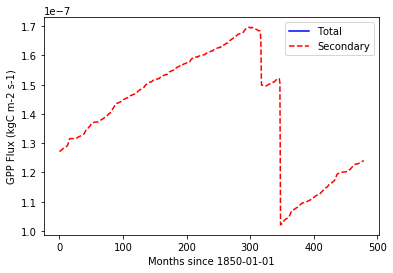

In [131]:
# Secondary biomass vs. total biomass, daily
plt.plot(gpp_ts[:,lat_pos,lon_pos], 'b-')
plt.plot(gpp_sec[:,lat_pos,lon_pos], 'r--')
plt.legend(['Total','Secondary'])
plt.xlabel('Months since 1850-01-01')
plt.ylabel('GPP Flux (kgC m-2 s-1)')

Text(0,0.5,'GPP Flux (kgC m-2 s-1)')

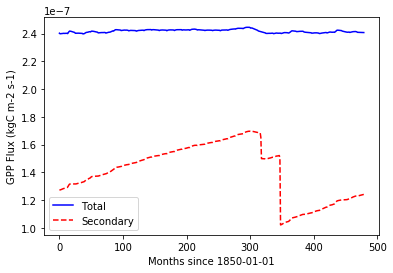

In [125]:
# Secondary biomass vs. total biomass, daily
plt.plot(gpp_tot[:,lat_pos,lon_pos], 'b-')
plt.plot(gpp_sec[:,lat_pos,lon_pos], 'r--')
plt.legend(['Total','Secondary'])
plt.xlabel('Months since 1850-01-01')
plt.ylabel('GPP Flux (kgC m-2 s-1)')

In [128]:
lai_ts[:,lat_pos,lon_pos]

array([13029.923], dtype=float32)

In [130]:
np.shape(gpp_ts)

(1L, 46L, 72L)

Text(0,0.5,'LAI (m2 m-2)')

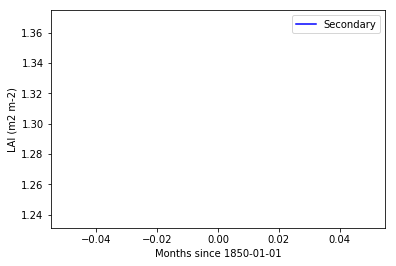

In [127]:
# Secondary biomass vs. total biomass, daily
plt.plot(lai_ts[:,lat_pos,lon_pos]/1e4, 'b-')
# plt.plot(lai_sec[:,lat_pos,lon_pos], 'r--')
plt.legend(['Secondary'])
plt.xlabel('Months since 1850-01-01')
plt.ylabel('LAI (m2 m-2)')

Text(0,0.5,'Area (fraction)')

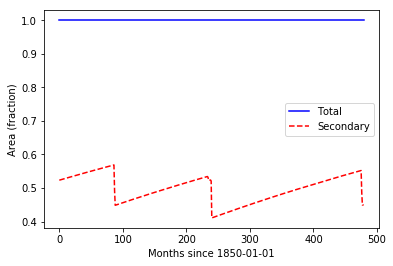

In [87]:
# Secondary biomass vs. total biomass, daily
plt.plot(area_tot[:,lat_pos,lon_pos], 'b-')
plt.plot(area_sec[:,lat_pos,lon_pos], 'r--')
plt.legend(['Total','Secondary'])
plt.xlabel('Months since 1850-01-01')
plt.ylabel('Area (fraction)')

Text(0,0.5,'Number of plants (# m-2)')

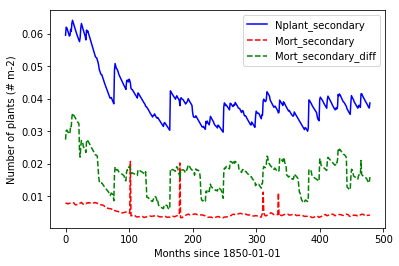

In [107]:
# Check mortality
mort_tot = age_mort+back_mort+starv_mort+fire_mort+freeze_mort+hydra_mort+impact_mort+logging_mort+scene_mort+termi_mort
mort_all = canopy_mort+ustory_mort
# Treat first 6 sizes as young forest
mort_sec_1 = np.nansum(mort_tot[:,1:6,:,:], 1)
mort_sec_2 = np.nansum(mort_all[:,1:6,:,:], 1)
nplant_sec = np.nansum(nplant[:,1:6,:,:], 1)

# Secondary biomass vs. total biomass, daily
plt.plot(nplant_sec[:,lat_pos,lon_pos], 'b-')
plt.plot(mort_sec_1[:,lat_pos,lon_pos], 'r--')
plt.plot(nplant[:,1,lat_pos,lon_pos], 'g--')

plt.legend(['Nplant_secondary','Mort_secondary','Mort_secondary_diff'])
plt.xlabel('Months since 1850-01-01')
plt.ylabel('Number of plants (# m-2)')



Text(0,0.5,'Vegetation C (kgC m-2)')

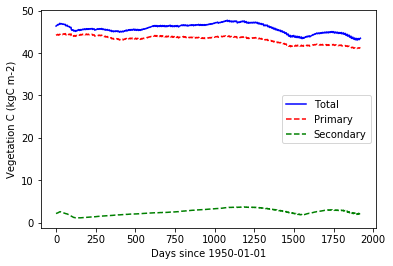

In [6]:
# Secondary biomass vs. total biomass, daily
plt.plot(biomass_ts[:,lat_pos,lon_pos], 'b-')
plt.plot(biomass_ts[:,lat_pos,lon_pos] - sec_biomass[:,lat_pos,lon_pos], 'r--')
plt.plot(sec_biomass[:,lat_pos,lon_pos], 'g--')
plt.legend(['Total','Primary','Secondary'])
plt.xlabel('Days since 1950-01-01')
plt.ylabel('Vegetation C (kgC m-2)')

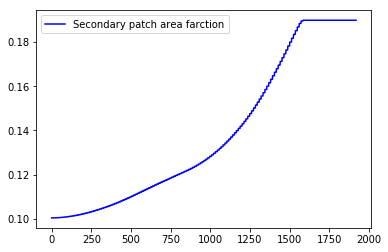

In [8]:
# Secondary patch area fraction
plt.plot(sec_frac[:,lat_pos,lon_pos], 'b-')
plt.legend(['Secondary patch area farction'])

Text(0,0.5,'Vegetation C (kgC m-2)')

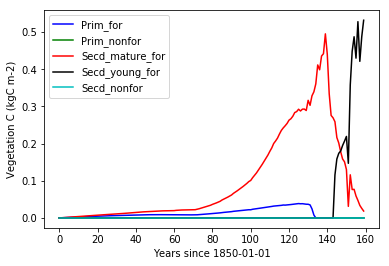

In [10]:
# Auxilliary data to check the primary and secondary harvest rate, annual
plt.plot(lu_hrv_c_vh1[0:160,lat_pos,lon_pos]/(site_area*(1-sec_frac[1919,lat_pos,lon_pos])), 'b-')
plt.plot(lu_hrv_c_vh2[0:160,lat_pos,lon_pos]/(site_area*(1-sec_frac[1919,lat_pos,lon_pos])), 'g-')
plt.plot(lu_hrv_c_sh1[0:160,lat_pos,lon_pos]/(site_area*sec_frac[1919,lat_pos,lon_pos]), 'r-')
plt.plot(lu_hrv_c_sh2[0:160,lat_pos,lon_pos]/(site_area*sec_frac[1919,lat_pos,lon_pos]), 'k-')
plt.plot(lu_hrv_c_sh3[0:160,lat_pos,lon_pos]/(site_area*sec_frac[1919,lat_pos,lon_pos]), 'c-')
plt.legend(['Prim_for', 'Prim_nonfor', 'Secd_mature_for', 'Secd_young_for', 'Secd_nonfor'])
plt.xlabel('Years since 1850-01-01')
plt.ylabel('Vegetation C (kgC m-2)')


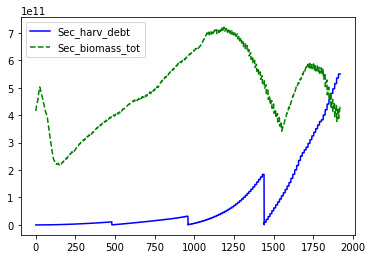

In [11]:
# Check harvest debt
# plt.plot(hrv_debt[:,lat_pos,lon_pos], 'r-')
plt.plot(hrv_debt_sec[:,lat_pos,lon_pos], 'b-')
plt.plot(sec_biomass[:,lat_pos,lon_pos]*site_area*nat_area_frac[0,lat_pos,lon_pos], 'g--')
plt.legend(['Sec_harv_debt','Sec_biomass_tot'])

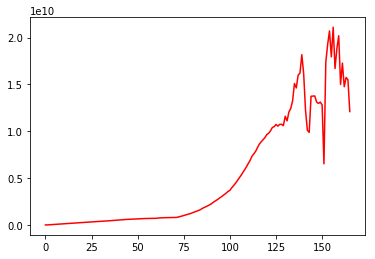

In [12]:
# Transfer secondary forest harvest debt into per year value
plt.plot(lu_hrv_c_sh1[:,lat_pos,lon_pos]+lu_hrv_c_sh2[:,lat_pos,lon_pos]+lu_hrv_c_sh3[:,lat_pos,lon_pos], 'r-')

In [151]:
# Check mortalities
plants_pft = nplants[0,:,lat_pos,lon_pos]
plants_sec_pft = nplants_sec[0,:,lat_pos,lon_pos]
plants_tot = np.nansum(nplants[0,:,lat_pos,lon_pos])
plants_sec_tot = np.nansum(nplants_sec[0,:,lat_pos,lon_pos])

mort_tot = np.nansum(age_mort[0,:,lat_pos,lon_pos]) + np.nansum(back_mort[0,:,lat_pos,lon_pos]) + \
      np.nansum(starv_mort[0,:,lat_pos,lon_pos]) + np.nansum(freeze_mort[0,:,lat_pos,lon_pos]) + \
      np.nansum(hydra_mort[0,:,lat_pos,lon_pos]) + np.nansum(logging_mort[0,:,lat_pos,lon_pos]) + \
      np.nansum(scene_mort[0,:,lat_pos,lon_pos])
mort_sec_tot = np.nansum(age_mort_sec[0,:,lat_pos,lon_pos]) + np.nansum(back_mort_sec[0,:,lat_pos,lon_pos]) + \
      np.nansum(starv_mort_sec[0,:,lat_pos,lon_pos]) + np.nansum(freeze_mort_sec[0,:,lat_pos,lon_pos]) + \
      np.nansum(hydra_mort_sec[0,:,lat_pos,lon_pos]) + np.nansum(logging_mort_sec[0,:,lat_pos,lon_pos]) + \
      np.nansum(scene_mort_sec[0,:,lat_pos,lon_pos])

rmort_tot = mort_tot/plants_tot
rmort_sec = mort_sec_tot/plants_sec_tot


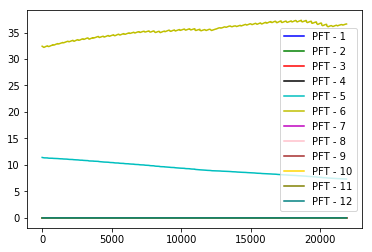

In [53]:
# Check forest biomass from each PFTs to see what is the issue on PFT level?
plt.plot(biomass_pft_ts[:,0,lat_pos,lon_pos], 'b-')
plt.plot(biomass_pft_ts[:,1,lat_pos,lon_pos], 'g-')
plt.plot(biomass_pft_ts[:,2,lat_pos,lon_pos], 'r-')
plt.plot(biomass_pft_ts[:,3,lat_pos,lon_pos], 'k-')
plt.plot(biomass_pft_ts[:,4,lat_pos,lon_pos], 'c-')
plt.plot(biomass_pft_ts[:,5,lat_pos,lon_pos], 'y-')
plt.plot(biomass_pft_ts[:,6,lat_pos,lon_pos], 'm-')
plt.plot(biomass_pft_ts[:,7,lat_pos,lon_pos], color = 'pink')
plt.plot(biomass_pft_ts[:,8,lat_pos,lon_pos], color = 'brown')
plt.plot(biomass_pft_ts[:,9,lat_pos,lon_pos], color = 'gold')
plt.plot(biomass_pft_ts[:,10,lat_pos,lon_pos], color = 'olive')
plt.plot(biomass_pft_ts[:,11,lat_pos,lon_pos], color = 'teal')
plt.legend(['PFT - 1', 'PFT - 2', 'PFT - 3', 'PFT - 4', 'PFT - 5', \
           'PFT - 6', 'PFT - 7', 'PFT - 8', 'PFT - 9', 'PFT - 10',  \
           'PFT - 11', 'PFT - 12'])


Text(0.5,1,'Site XX Productivities')

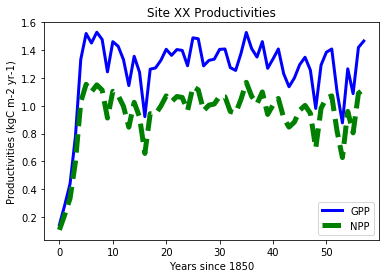

In [8]:
## Check spinup history + transient case for productivity
## For transient case the daily data are transferred into annual
gpp_yr = np.zeros((nyr_spinup))
npp_yr = np.zeros((nyr_spinup))
for iyr in np.arange(0,nyr_spinup):
    id_beg = iyr*12
    id_end = (iyr+1)*12-1
    gpp_yr[iyr] = np.nanmean(gpp_spinup[id_beg:id_end])*3600*24*365
    npp_yr[iyr] = np.nanmean(npp_spinup[id_beg:id_end])*3600*24*365

plt.plot(gpp_yr, 'b-', linewidth=3)
plt.plot(npp_yr, 'g--', linewidth=5)
plt.xlabel('Years since 1850')
plt.ylabel('Productivities (kgC m-2 yr-1)')
plt.legend(['GPP', 'NPP'])
plt.title('Site XX Productivities')
# plt.savefig('validate_cbased_luc_frac.png')

Text(0.5,1,'Site XX Vegetation C from FATES')

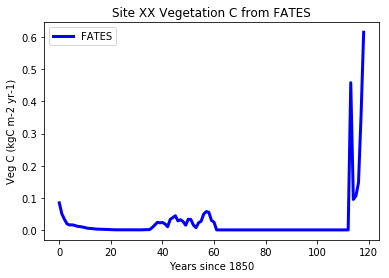

In [93]:
## Validate total biomass
# Annual mean, spinup + transient
veg_c_yr = np.zeros((nyr_spinup+nyr_transient))
for iyr in np.arange(0,nyr_spinup):
    id_beg = iyr*12
    id_end = (iyr+1)*12-1
    veg_c_yr[iyr] = np.nanmean(vegc_spinup[id_beg:id_end])
    npatch_yr[iyr] = np.nanmean(npatch_spinip[id_beg:id_end])
for iyr in np.arange(0,nyr_transient):
    id_beg = iyr*365
    id_end = (iyr+1)*365-1
    veg_c_yr[nyr_spinup+iyr] = np.nanmean(vegc_transient[id_beg:id_end])

# Density * area * natural land fraction
veg_c_mass_yr = veg_c_yr * site_area * np.nansum(area_ag_spinup[0,:,0])

plt.plot(veg_c_yr, 'b-', linewidth=3)
# plt.plot(veg_c_mass_yr[58:58+nyr_transient], 'b-', linewidth=5)
# plt.plot(lu_hrv_c[0:nyr_transient,0,0], 'g--', linewidth=5)
plt.xlabel('Years since 1850')
plt.ylabel('Veg C (kgC m-2 yr-1)')
plt.legend(['FATES', 'LUH2'])
plt.title('Site XX Vegetation C from FATES')
# plt.savefig('validate_cbased_hrv_c.png')


Text(0.5,1,'Site XX Vegetation C from FATES')

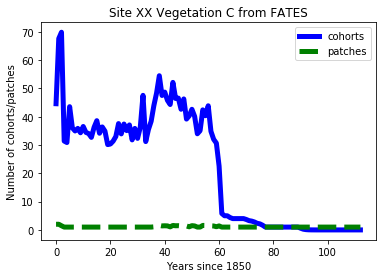

In [119]:
## Validate biomass from different PFTs
biomass_pf_yr = np.zeros((nyr_spinup, 2))
npatch_yr = np.zeros((nyr_spinup))
ncohort_yr = np.zeros((nyr_spinup))
for iyr in np.arange(0,nyr_spinup):
    id_beg = iyr*12
    id_end = (iyr+1)*12-1
    npatch_yr[iyr] = np.nanmean(npatch_spinip[id_beg:id_end])
    ncohort_yr[iyr] = np.nanmean(ncohort_spinip[id_beg:id_end])
    biomass_pf_yr[iyr,0] = np.nansum(np.nanmean(biomass_pf_spinup[id_beg:id_end,1,0], 0), 0)
    biomass_pf_yr[iyr,1] = np.nansum(np.nanmean(biomass_pf_spinup[id_beg:id_end,11,0], 0), 0)

# plt.plot(biomass_pf_yr[:,0], 'b-', linewidth=5)
# plt.plot(biomass_pf_yr[:,1], 'g--', linewidth=5)
plt.plot(ncohort_yr, 'b-', linewidth=5)
plt.plot(npatch_yr, 'g--', linewidth=5)
plt.xlabel('Years since 1850')
plt.ylabel('Number of cohorts/patches')
plt.legend(['cohorts', 'patches'])
# plt.ylabel('Veg C (kgC m-2 yr-1)')
# plt.legend(['Woody', 'Non-woody'])
plt.title('Site XX Vegetation C from FATES')



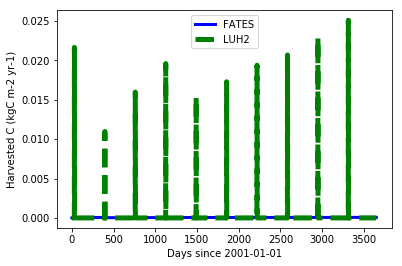

In [9]:
hrv_pool_nohrv = hrv_flux10c_nohrv_elm + hrv_flux100c_nohrv_elm
hrv_pool_wthrv = hrv_flux10c_wthrv_elm + hrv_flux100c_wthrv_elm
plt.plot(hrv_c_nohrv, 'b-', linewidth=3)
plt.plot(hrv_c_wthrv, 'g--', linewidth=5)
plt.xlabel('Days since 2001-01-01')
plt.ylabel('Harvested C (gC m-2)')
plt.legend(['Spike', 'Uniform'])


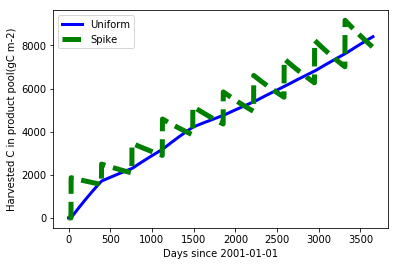

In [13]:
hrv_c_nohrv = hrv_10c_nohrv + hrv_100c_nohrv
hrv_c_wthrv = hrv_10c_wthrv + hrv_100c_wthrv
plt.plot(hrv_c_nohrv, 'b-', linewidth=3)
plt.plot(hrv_c_wthrv, 'g--', linewidth=5)
plt.xlabel('Days since 2001-01-01')
plt.ylabel('Harvested C in product pool(gC m-2)')
plt.legend(['Uniform', 'Spike'])
plt.savefig('comparison_uniform_vs_spike.png')

Text(0.5,1,'Check total biomass')

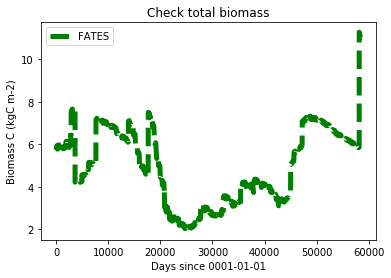

In [13]:
# Check total biomass
plt.plot(biomass_den, 'g--', linewidth=5)
plt.xlabel('Days since 0001-01-01')
plt.ylabel('Biomass C (kgC m-2)')
plt.legend(['FATES'])
plt.title('Check total biomass')

